In [1]:
import math
from math import radians, degrees
import numpy as np
import casadi
from casadi import sin, cos, atan2, pi
import matplotlib.pyplot as plt
%matplotlib widget

# link lengths of front arm (mm), refer to Jack's IK sketch
a1 = 23.785 #back input link
a2 = 72.253 #shin back
a3 = 35.190 #shin top
a4 = 47.276 #shin forward
a5 = 29.621 #between shin and front input link
a6 = 25.939 #front input link
a7 = 20.200 #between input links
theta7 = radians(34.759) #angle of back input pt to front input pt to world x-axis
theta2 = radians(33.838) #angle between top and back of shin

sin7 = math.sin(theta7) 
cos7 = math.cos(theta7)

theta1_range = [radians(75.8), radians(360-6)]
theta6_range = [radians(-103.1), radians(172.3)]

theta_b_min = radians(47.9)
theta_b_max = radians(169.297)
theta_t_min = radians(23.746)
theta_t_max = radians(174.406)
theta_f_min = radians(49.966)
theta_f_max = radians(142.954)
# theta_i1_min = radians(13.84)

In [93]:
def fk(theta1, theta6, guess=None):
    if(guess == None):
        theta3_guess = radians(-23.3)
        theta5_guess = radians(-166.6)
        sin3_g = sin(theta3_guess)
        cos3_g = cos(theta3_guess)
        sin5_g = sin(theta5_guess)
        cos5_g = cos(theta5_guess)
        guess = [sin3_g, cos3_g, sin5_g, cos5_g]
        
    opti = casadi.Opti()
    sin1 = math.sin(theta1)
    cos1 = math.cos(theta1) 
    sin6 = math.sin(theta6)
    cos6 = math.cos(theta6)

    sin3 = opti.variable()
    cos3 = opti.variable()
    sin5 = opti.variable()
    cos5 = opti.variable()

    opti.set_initial(sin3, guess[0])
    opti.set_initial(cos3, guess[1])
    opti.set_initial(sin5, guess[2])
    opti.set_initial(cos5, guess[3])

    obj = (a1*cos1 + a3*cos3 - (a7*cos7 + a6*cos6 + a5*cos5))**2 + (a1*sin1 + a3*sin3 - (a7*sin7 + a6*sin6 + a5*sin5))**2
    opti.minimize(obj)
    opti.subject_to(sin3**2 + cos3**2 == 1)
    opti.subject_to(sin5**2 + cos5**2 == 1)

    theta3 = atan2(sin3,cos3)

    p1 = (a1*cos1, a1*sin1)
    p2 = (p1[0] + a2*cos(theta3 - theta2), p1[1] + a2*sin(theta3 - theta2))
    p5 = (p1[0] + a3*cos3, p1[1] + a3*sin3)
    p7 = (a7*cos7, a7*sin7)
    p6 = (p7[0] + a6*cos6, p7[1] + a6*sin6)

    neg_cos_theta_b = -cos(atan2(-p1[1], -p1[0]) - atan2(p2[1] - p1[1], p2[0] - p1[0]) - (theta_b_min + theta_b_max)/2)
    neg_cos_theta_t = -cos(-atan2(p7[1]-p6[1], p7[0]-p6[0]) + atan2(p5[1] - p6[1], p5[0] - p6[0]) - (theta_t_min + theta_t_max)/2)
    neg_cos_theta_f = -cos(atan2(p1[1]-p5[1], p1[0]-p5[0]) - atan2(p6[1] - p5[1], p6[0] - p5[0]) - (theta_f_min + theta_f_max)/2)

    opti.subject_to(neg_cos_theta_b <= -cos((theta_b_min - theta_b_max)/2))
    opti.subject_to(neg_cos_theta_t <= -cos((theta_t_min - theta_t_max)/2))
    opti.subject_to(neg_cos_theta_f <= -cos((theta_f_min - theta_f_max)/2))

    p_opts = dict(print_time=False, verbose=False)
    s_opts = dict(print_level=0)
    opti.solver('ipopt', p_opts, s_opts)
    # opti.solver('ipopt')
    # sol = opti.solve()
    try:
        sol = opti.solve()
        return sol.value(p2[0]), sol.value(p2[1]), sol.value(obj)
    except:
        return 0, 0, 999


theta1_n = radians(172)
theta6_n = radians(-40)

fk(theta1_n, theta6_n)

(11.68386880408498, -59.76767212919772, 3.592148750562786e-18)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


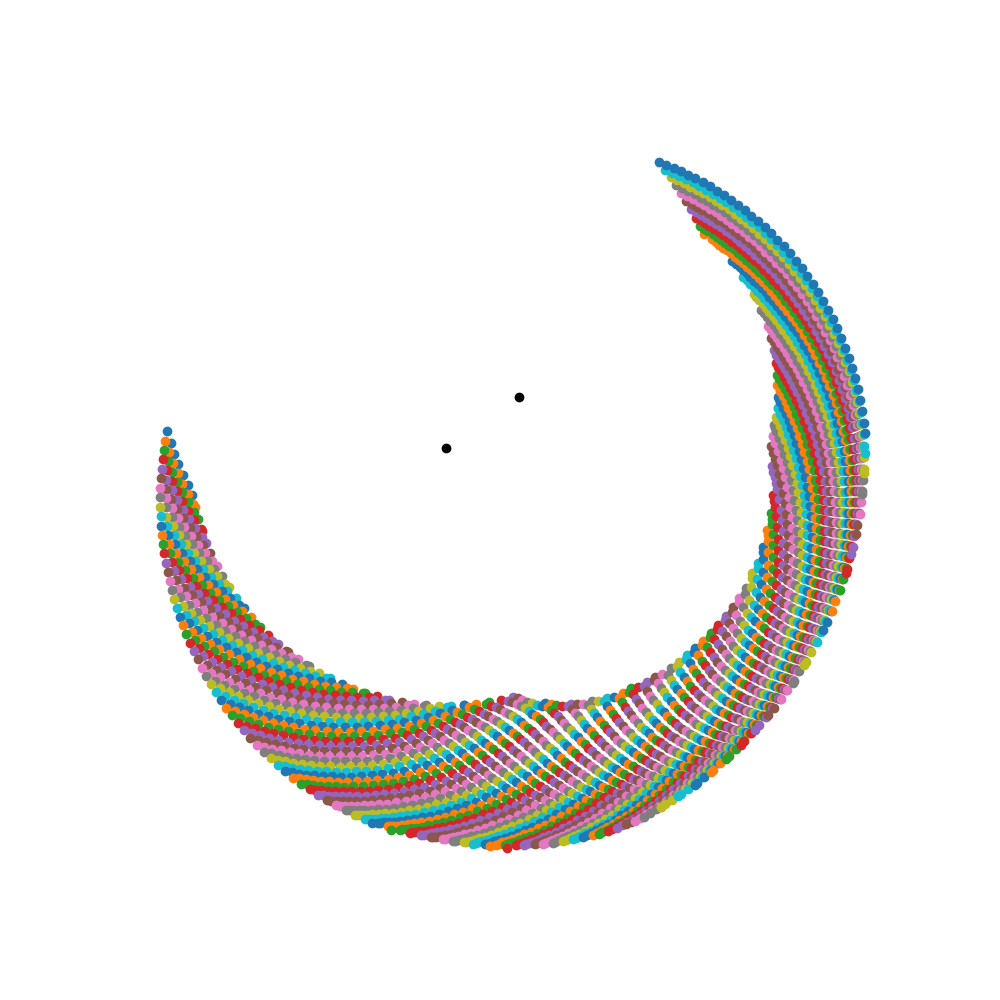

In [95]:
n = 100 #pts per line sweep
theta1_grid = np.linspace(theta1_range[0], theta1_range[1], n+1)
theta6_grid = np.linspace(theta6_range[0], theta6_range[1], n+1)

LOAD_FROM_FILE = False
# LOAD_FROM_FILE = False

if(LOAD_FROM_FILE):
    workspace = np.load('arm_workspace_100.npy')
else:
    plt.figure(figsize=(10,10))
    plt.gca().set_aspect('equal', adjustable='box')
    i = 0
    workspace = []
    for theta1 in theta1_grid:
        i+=1
        print(i)
        theta6_sweep = []
        for theta6 in theta6_grid:
            p2x, p2y, obj = fk(theta1, theta6)
            if(obj < 1): #solution found
                theta6_sweep.append([p2x,p2y])
            else:
                theta6_sweep.append([np.nan, np.nan])
        theta6_sweep = np.array(theta6_sweep)

        plt.scatter(theta6_sweep[:,0], theta6_sweep[:,1])
        workspace.append(theta6_sweep)
    workspace = np.array(workspace)

    plt.scatter(0, 0, color='k')
    p7 = (a7*cos(theta7), a7*sin(theta7))
    plt.scatter(p7[0], p7[1], color='k')
    plt.axis('off')

    from datetime import datetime
    current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f'saved_workspaces/arm_{n}_{current_timestamp}'
    plt.savefig(filename+'.png', transparent=True, bbox_inches='tight', pad_inches=0)
    np.save(filename+'.npy', workspace)

In [255]:
6.3*(100/20)**2

157.5

Text(0, 0.5, 'front servo (rad)')

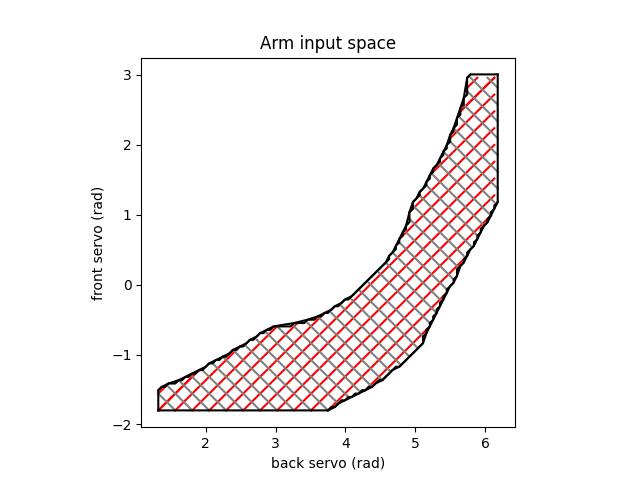

In [104]:
grid_spacing = 5

plt.figure()
plt.gca().set_aspect('equal', adjustable='box')
# valid_spots = []
# for i in range(n):
#     for j in range(n):
#         if(np.isnan(workspace[i,j,0])):
#             continue
#         diag_started = True
#         valid_spots.append([theta1_grid[i], theta6_grid[j]])

# valid_spots = np.array(valid_spots)
# plt.scatter(valid_spots[:,0], valid_spots[:,1], s=1)



for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n):
        if(5*i+j >= n):
            continue
        p = (5*i+j, j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([theta1_grid[p[0]], theta6_grid[p[1]]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'red')

for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n):
        if(5*i+j >= n):
            continue
        p = (j, 5*i+j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([theta1_grid[p[0]], theta6_grid[p[1]]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'red')

for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n):
        p = (n-(5*i+j), j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([theta1_grid[p[0]], theta6_grid[p[1]]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'gray')


edge_bot = []
for i in range(n+1):
    for j in range(n):
        if not np.isnan(workspace[i, j, 0]):
            edge_bot.append([theta1_grid[i], theta6_grid[j]])
            break
edge_bot = np.array(edge_bot)
edge_top = []
for i in range(n+1):
    for j in range(n,0,-1):
        if not np.isnan(workspace[i, j, 0]):
            edge_top.append([theta1_grid[i], theta6_grid[j]])
            break
edge_top = np.array(edge_top)
edge_left = []
for i in range(n+1):
    for j in range(n):
        if not np.isnan(workspace[j, i, 0]):
            edge_left.append([theta1_grid[j], theta6_grid[i]])
            break
edge_left = np.array(edge_left)
edge_right = []
for i in range(n+1):
    for j in range(n,0,-1):
        if not np.isnan(workspace[j, i, 0]):
            edge_right.append([theta1_grid[j], theta6_grid[i]])
            break
edge_right = np.array(edge_right)

# from scipy.ndimage import gaussian_filter1d
# xsmoothed = gaussian_filter1d(edge_top[:,0], sigma=2)
# ysmoothed = gaussian_filter1d(edge_top[:,1], sigma=2)
# plt.plot(xsmoothed, ysmoothed, 'k')


plt.plot(edge_bot[:,0], edge_bot[:,1], 'k')
plt.plot(edge_top[:,0], edge_top[:,1], 'k')
plt.plot(edge_left[:,0], edge_left[:,1], 'k')
plt.plot(edge_right[:,0], edge_right[:,1], 'k')

plt.title("Arm input space")
plt.xlabel('back servo (rad)')
plt.ylabel('front servo (rad)')




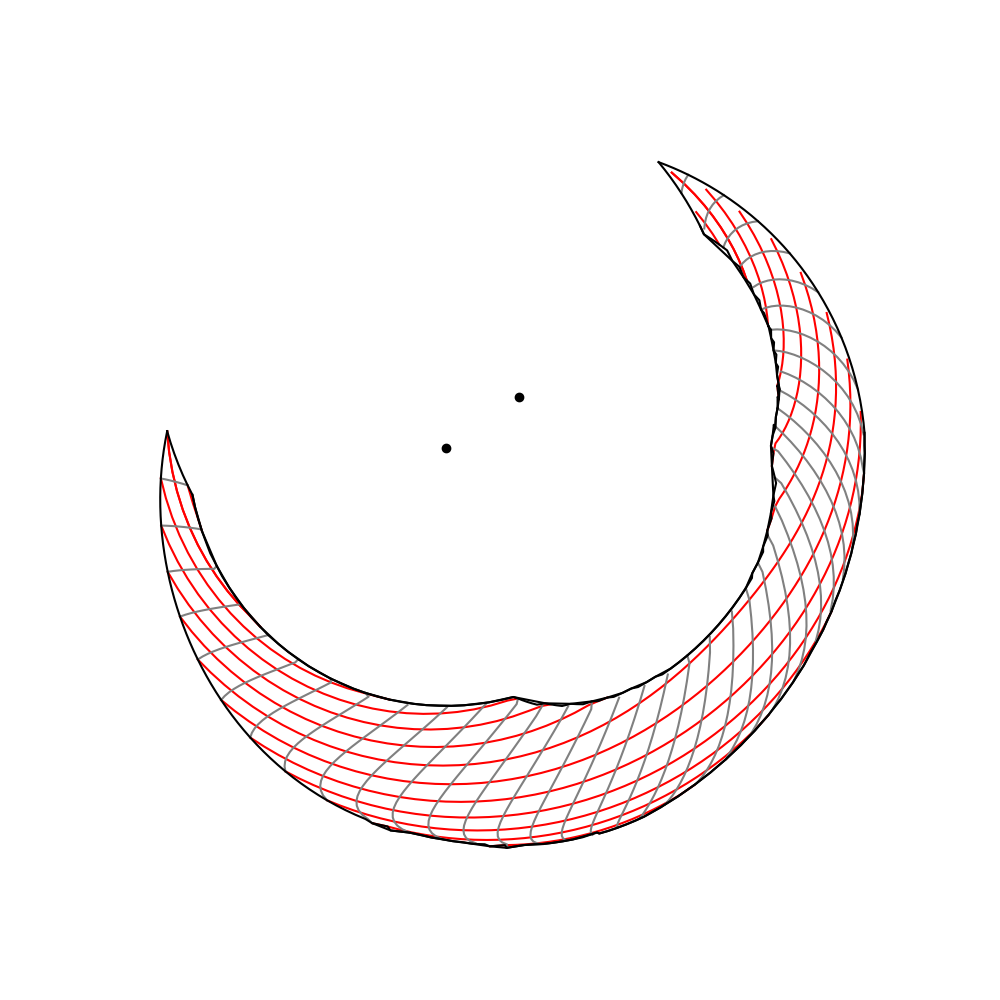

In [105]:
grid_spacing = 5

plt.figure(figsize=(10,10))
plt.gca().set_aspect('equal', adjustable='box')
# valid_spots = []
# for i in range(n):
#     for j in range(n):
#         if(np.isnan(workspace[i,j,0])):
#             continue
#         diag_started = True
#         valid_spots.append([theta1_grid[i], theta6_grid[j]])

# valid_spots = np.array(valid_spots)
# plt.scatter(valid_spots[:,0], valid_spots[:,1], s=1)



for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n+1):
        if(5*i+j >= n):
            continue
        p = (5*i+j, j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([workspace[p[0],p[1],0], workspace[p[0],p[1],1]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'r')

for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n+1):
        if(5*i+j >= n):
            continue
        p = (j, 5*i+j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([workspace[p[0],p[1],0], workspace[p[0],p[1],1]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'r')


for i in range(n//grid_spacing):
    diag = [[]]
    last_was_nan = True
    n_segments = 0
    for j in range(n+1):
        p = (n-(5*i+j), j)
        if(np.isnan(workspace[p[0],p[1],0])):
            last_was_nan = True
            continue
        if(last_was_nan):
            n_segments += 1
            diag.append([])
        diag[n_segments-1].append([workspace[p[0],p[1],0], workspace[p[0],p[1],1]])
        last_was_nan = False

    for segment in diag:
        segment = np.array(segment)
        if(len(segment) >= 2):
            plt.plot(segment[:,0], segment[:,1], 'gray')


edge_bot = []
for i in range(n+1):
    for j in range(n):
        if not np.isnan(workspace[i, j, 0]):
            edge_bot.append([workspace[i,j,0], workspace[i,j,1]])
            break
edge_bot = np.array(edge_bot)
edge_top = []
for i in range(n+1):
    for j in range(n,0,-1):
        if not np.isnan(workspace[i, j, 0]):
            edge_top.append([workspace[i,j,0], workspace[i,j,1]])
            break
edge_top = np.array(edge_top)
edge_left = []
for i in range(n+1):
    for j in range(n):
        if not np.isnan(workspace[j, i, 0]):
            edge_left.append([workspace[j,i,0], workspace[j,i,1]])
            break
edge_left = np.array(edge_left)
edge_right = []
for i in range(n+1):
    for j in range(n,0,-1):
        if not np.isnan(workspace[j, i, 0]):
            edge_right.append([workspace[j,i,0], workspace[j,i,1]])
            break
edge_right = np.array(edge_right)
plt.plot(edge_bot[:,0], edge_bot[:,1], 'k')
plt.plot(edge_top[:,0], edge_top[:,1], 'k')
plt.plot(edge_left[:,0], edge_left[:,1], 'k')
plt.plot(edge_right[:,0], edge_right[:,1], 'k')


plt.scatter(0, 0, color='k')
p7 = (a7*cos(theta7), a7*sin(theta7))
plt.scatter(p7[0], p7[1], color='k')
plt.axis('off')
plt.savefig('armworkspace3.png', transparent=True, bbox_inches='tight', pad_inches=0)


In [34]:
workspace

array([[[-63.80722132,   3.80968123],
        [-63.03830656,   1.21761279],
        [-62.1818375 ,  -1.31909491],
        ...,
        [         nan,          nan],
        [         nan,          nan],
        [         nan,          nan]],

       [[-64.22258188,   1.65815122],
        [-63.36744128,  -0.89622189],
        [-62.42725155,  -3.39289664],
        ...,
        [         nan,          nan],
        [         nan,          nan],
        [         nan,          nan]],

       [[-64.57373095,  -0.49981108],
        [-63.63459993,  -3.01464512],
        [-62.61280529,  -5.46978899],
        ...,
        [         nan,          nan],
        [         nan,          nan],
        [         nan,          nan]],

       ...,

       [[         nan,          nan],
        [         nan,          nan],
        [         nan,          nan],
        ...,
        [ 54.3163613 ,  60.49008698],
        [ 52.81157615,  61.18420122],
        [ 51.294997  ,  61.84205519]],

       [[      

In [32]:
plt.close('all')